# Usando regresiones lineales para identificar puntos de datos que tengan influencia significativa  
  
Vamos a utilizar modelos estadísticos para identificar valores atípicos (outliers).  
Ventajas:
1. Las técnicas estadísticas nos permiten ser menos dependientes de la distribución de la variable de interés.
2. Consideran más factores que los análisis univariados y bivariados.
3. Esto quiere decir que nos permiten identificar valores atípicos que no se revelan en una primera instancia.

Incluimos nuestros paquetes y utilizaremos los datos del covid

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
covid = pd.read_csv("data/covidtotals.csv")
covid.set_index("iso_code", inplace =True)

In [3]:
covid.head()

,lastdate,location,total_cases,total_deaths,total_cases_pm,total_deaths_pm,population,pop_density,median_age,gdp_per_capita,hosp_beds
iso_code,,,,,,,,,,,
AFG,2020-06-01,Afghanistan,15205,257,390.589,6.602,38928341.0,54.422,18.6,1803.987,0.50
ALB,2020-06-01,Albania,1137,33,395.093,11.467,2877800.0,104.871,38.0,11803.431,2.89
DZA,2020-06-01,Algeria,9394,653,214.225,14.891,43851043.0,17.348,29.1,13913.839,1.90
AND,2020-06-01,Andorra,764,51,9888.048,660.066,77265.0,163.755,NaN,NaN,NaN
AGO,2020-06-01,Angola,86,4,2.617,0.122,32866268.0,23.890,16.8,5819.495,NaN


Existen razon conceptuales para pensar que la densidad de población ``population_density``, la edad promedio ``median_age`` y el PIB per capita ``gdp_per_capita`` pueden ser predictores del total de casos de covid por millón de habitantes ``total_cases_pm``.

In [4]:
variables =['pop_density', 'median_age', 'gdp_per_capita']

In [5]:
analisis = covid.loc[:,['total_cases_pm']+ variables].dropna()

In [17]:
analisis.describe().T

,count,mean,std,min,25%,50%,75%,max
total_cases_pm,175.0,1134.015709,2101.363772,0.00,67.4480,263.413,1357.506,19753.146
pop_density,175.0,247.151863,822.398967,1.98,36.0660,82.328,207.960,7915.731
median_age,175.0,30.537143,9.117751,15.10,22.3000,29.700,38.700,48.200
gdp_per_capita,175.0,19008.385423,19673.386571,661.24,4458.2025,12951.839,27467.146,116935.600


### Ajuste a un modelo de regresión lineal

In [7]:
def obtenerML(df):
    Y = df.total_cases_pm
    X = df[['pop_density', 'median_age','gdp_per_capita']]
    X = sm.add_constant(X)
    return sm.OLS(Y,X).fit()

In [8]:
ml = obtenerML(analisis)

In [9]:
ml.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         total_cases_pm   R-squared:                       0.520
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     61.81
Date:                Sat, 21 Jan 2023   Prob (F-statistic):           4.06e-27
Time:                        12:07:22   Log-Likelihood:                -1522.4
No. Observations:                 175   AIC:                             3053.
Df Residuals:                     171   BIC:                             3065.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            944.4731    426.712      2.213      0.028     102.172    1786.774
pop_density       -0.2057      0.142     -1.447      0.150      -0.486       0.075
median_age       -49.4398     16.013     -3.088      0.002     -81.048     -17.832
gdp_per_capita     0.0921      0.008     12.015      0.000       0.077       0.107
==============================================================================
Omnibus:                      105.361   Durbin-Watson:                   2.194
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1182.641
Skew:                           1.967   Prob(JB):                    1.56e-257
Kurtosis:                      15.113   Cond. No.                     1.05e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Detectar paises que tienen una influencia descomunal en el modelo

In [10]:
influencia = ml.get_influence().summary_frame()

In [11]:
influencia.loc[influencia.cooks_d>0.5, ['cooks_d']]


,cooks_d
iso_code,
HKG,0.780662
QAT,5.080180


In [15]:
covid.loc[['HKG','QAT']][['total_cases_pm','pop_density','median_age','gdp_per_capita']]

,total_cases_pm,pop_density,median_age,gdp_per_capita
iso_code,,,,
HKG,0.000,7039.714,44.8,56054.92
QAT,19753.146,227.322,31.9,116935.60


In [16]:
covid.loc[['SGP','CHL']][['total_cases_pm','pop_density','median_age','gdp_per_capita']]

,total_cases_pm,pop_density,median_age,gdp_per_capita
iso_code,,,,
SGP,5962.727,7915.731,42.4,85535.383
CHL,5214.841,24.282,35.4,22767.037


#### Gráfico de Influencia  
  
Paises con una distancia de Cook grande tendrán circulos de mayor diámetro. 

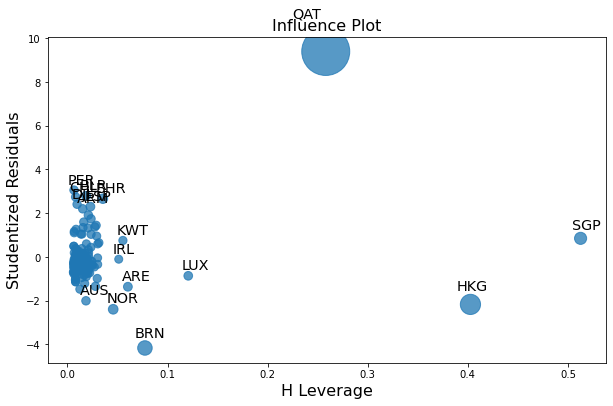

In [23]:
fig, ax = plt.subplots(figsize=(10,6))
sm.graphics.influence_plot(ml, ax= ax, criterion="cooks")
plt.show()

In [24]:
covid_sin_ol= analisis.loc[influencia.cooks_d<0.5]

In [25]:
ml = obtenerML(covid_sin_ol)

In [26]:
ml.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         total_cases_pm   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                     46.56
Date:                Sat, 21 Jan 2023   Prob (F-statistic):           5.52e-22
Time:                        12:28:52   Log-Likelihood:                -1464.8
No. Observations:                 173   AIC:                             2938.
Df Residuals:                     169   BIC:                             2950.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             44.0854    349.924      0.126      0.900    -646.700     734.870
pop_density        0.2423      0.145      1.666      0.098      -0.045       0.529
median_age        -2.5165     13.526     -0.186      0.853     -29.217      24.184
gdp_per_capita     0.0557      0.007      7.875      0.000       0.042       0.070
==============================================================================
Omnibus:                       53.262   Durbin-Watson:                   2.166
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              123.935
Skew:                           1.347   Prob(JB):                     1.22e-27
Kurtosis:                       6.152   Cond. No.                     1.01e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.01e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

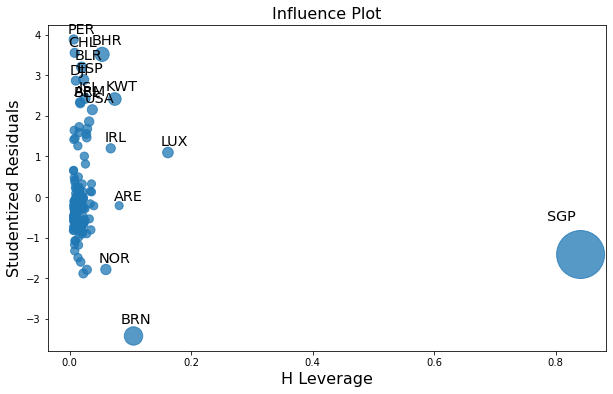

In [27]:
fig, ax = plt.subplots(figsize=(10,6))
sm.graphics.influence_plot(ml, ax= ax, criterion="cooks")
plt.show()